In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


/home/x1b3d3ad/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


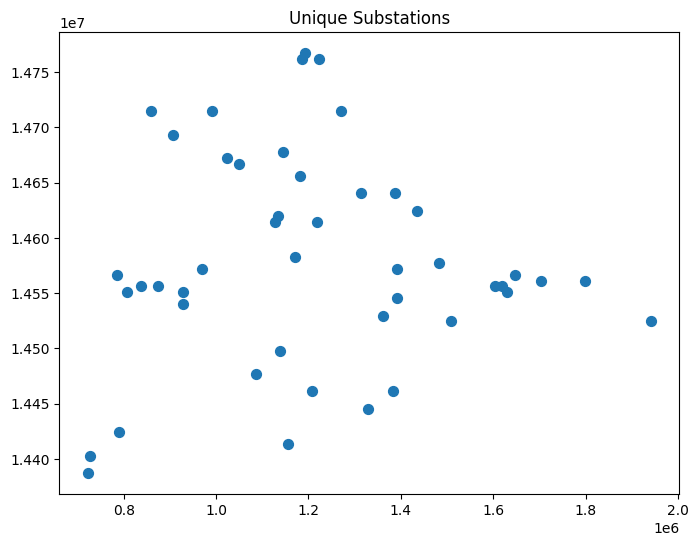

In [2]:
""" Plot unique substations on the x-y plane with seaborn """

df = pd.read_csv('data/RRCA_baseflow.csv')
unique_substations = df[['Segment_id', 'x', 'y']].drop_duplicates().reset_index(drop=True)
unique_substations.head()

# Plot the unique substations
plt.figure(figsize=(8, 6))
plt.scatter(unique_substations['x'], unique_substations['y'], s=50)
plt.title('Unique Substations')
plt.show()

   Segment_id        x         y  knn_id
0         144  1086190  14476800       9
1         154  1138990  14497920       9
2         176   790510  14424000       4
3         171  1508590  14524320      16
4         152  1360750  14529600      12
5          55  1133710  14619360       2
6         118  1186510  14761920       6
7          65   838030  14556000      10
8          64  1645870  14566560       3
9          63  1619470  14556000       3


/home/x1b3d3ad/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


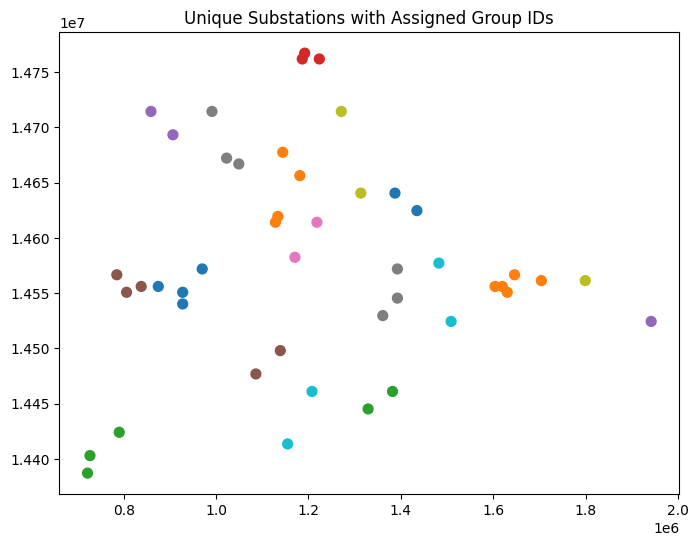

In [3]:
# Goal: for each substation, sort the distances from each data point. 
# there will be n groups to assign to each substation. Minimize the sum of the distances 
# for each group.
assigned_group_ids = []

# Assign group IDs based on K-means clustering of distances
kmeans = KMeans(n_clusters=18, random_state=0)
kmeans.fit(unique_substations[['x', 'y']])
cluster_ids = kmeans.labels_

# Assign cluster IDs to the assigned_group_ids list
assigned_group_ids = cluster_ids.tolist()

# Add the assigned group IDs to the DataFrame as a new column
unique_substations['knn_id'] = assigned_group_ids

print(unique_substations.head(10))
unique_substations_filtered = unique_substations[unique_substations['knn_id'] == 0]

# Plot the unique substations with assigned group IDs
plt.figure(figsize=(8, 6))
plt.scatter(unique_substations['x'], unique_substations['y'], c=unique_substations['knn_id'], cmap='tab10', s=50)
plt.title('Unique Substations with Assigned Group IDs')
plt.show()


In [6]:
""" Okay, now I'm going to preprocess the data 
    Standardize the data, and take the average 
    value for the grouped stations """
df = pd.read_csv('data/RRCA_baseflow.csv')

# Standardize the data
scaler = StandardScaler()
df[['Evapotranspiration', 'Precipitation', 'Irrigation_pumping', 'Observed']] = scaler.fit_transform(df[['Evapotranspiration', 'Precipitation', 'Irrigation_pumping', 'Observed']])

# Convert the date to a datetime object
df['Date'] = df['Date'].apply(lambda x: x-693963)
df['Date'] = pd.to_datetime(df['Date'], unit='D', origin='1900-01-01')

# Now I'm going to add the assigned group IDs to the main DataFrame
df = df.merge(unique_substations, on=['Segment_id', 'x', 'y'], how='left')

# Aggregate the data by assigned ID's and data 
df_grouped = df.groupby(['knn_id', 'Date']).mean().reset_index()
df_grouped.drop(columns=['Segment_id', 'x', 'y'], inplace=True)
df_grouped.to_csv('data/RRCA_baseflow_grouped.csv', index=False)

display(df_grouped.head(10))

,knn_id,Date,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,0,14516,-0.223385,0.112678,0.331410,-0.161057
1,0,14546,-0.438090,0.112678,0.331410,0.213770
2,0,14577,-0.684370,0.112678,0.331410,0.487509
3,0,14608,-0.848556,-0.058546,0.331410,0.659564
4,0,14637,-0.621221,-0.058546,0.331410,0.841247
5,0,14668,-0.848556,-0.058546,0.331410,1.040275
6,0,14698,0.111302,-0.058546,0.331410,0.876081
7,0,14729,1.232190,-0.058546,0.331410,0.307430
8,0,14759,1.923667,-0.058546,-0.605727,-0.094370
9,0,14790,2.201521,-0.058546,-1.112897,-0.312057


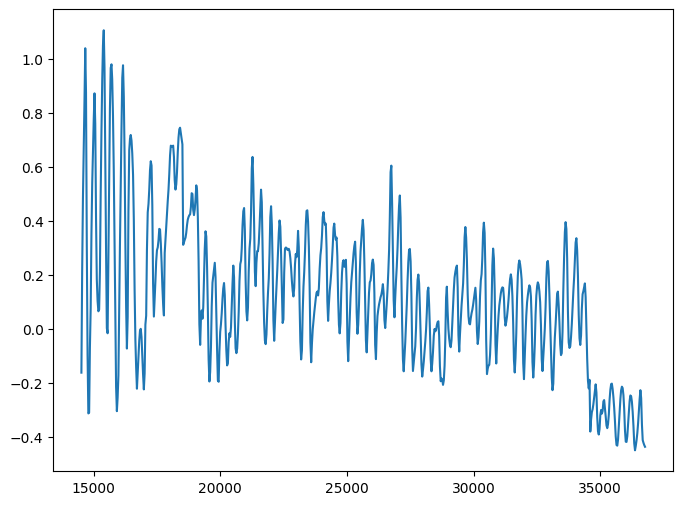

In [7]:
""" Now we need to graph the data and figure out what is going on"""

group_0 = df_grouped[df_grouped['knn_id'] == 0]
plt.figure(figsize=(8, 6))
plt.plot(group_0['Date'], group_0['Observed'], label='Observed')
plt.show()